In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Step 1: Start Spark Session
spark = SparkSession.builder \
    .appName("PCA_before_KMeans") \
    .getOrCreate()

# Step 2: Load Big Data
df = spark.read.csv("segmentation data.csv", header=True, inferSchema=True)
df.show(5)
df.printSchema()

# Step 3: Select only numeric columns
# Original:
# numeric_cols = [field.name for field in df.schema.fields if str(field.dataType) in ['IntegerType', 'DoubleType']]
# Modified to include more data types and handle nulls:
import pyspark.sql.types as types
numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, (types.IntegerType, types.DoubleType, types.LongType, types.FloatType))]

# Additional check to ensure numeric_cols is not empty:
if not numeric_cols:
    raise ValueError("No numeric columns found in the DataFrame. Please check the data types or the input file.")

# Step 4: Assemble features
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df)

# Step 5: Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# Step 6: Apply PCA (reduce to 2 or 3 components)
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

# Step 7: Apply KMeans on PCA-reduced features
kmeans = KMeans(featuresCol="pcaFeatures", predictionCol="cluster", k=3)
model = kmeans.fit(df_pca)
clustered = model.transform(df_pca)

# Step 8: Evaluate Clustering
evaluator = ClusteringEvaluator(featuresCol="pcaFeatures", predictionCol="cluster", metricName="silhouette")
silhouette = evaluator.evaluate(clustered)

print(f"Silhouette Score = {silhouette}")
print(f"Cluster Centers:\n{model.clusterCenters()}")

# Step 9: Show cluster results
clustered.select(numeric_cols + ["cluster"]).show(10)


+---------+---+--------------+---+---------+------+----------+---------------+
|       ID|Sex|Marital status|Age|Education|Income|Occupation|Settlement size|
+---------+---+--------------+---+---------+------+----------+---------------+
|100000001|  0|             0| 67|        2|124670|         1|              2|
|100000002|  1|             1| 22|        1|150773|         1|              2|
|100000003|  0|             0| 49|        1| 89210|         0|              0|
|100000004|  0|             0| 45|        1|171565|         1|              1|
|100000005|  0|             0| 53|        1|149031|         1|              1|
+---------+---+--------------+---+---------+------+----------+---------------+
only showing top 5 rows

root
 |-- ID: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- Marital status: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Occupation: integer

In [ ]:
"""
Tools Used:

PySpark: Used for distributed processing of large datasets.

MLlib (Spark ML): Provides scalable implementations of PCA, StandardScaler, KMeans, etc.

ClusteringEvaluator: Used to compute the silhouette score for cluster quality.

Key Concepts:

PCA (Principal Component Analysis): A dimensionality reduction technique that transforms high-dimensional data into fewer principal components while preserving variance.

KMeans Clustering: An unsupervised ML algorithm that partitions data into k distinct clusters based on feature similarity.

Workflow Summary:

SparkSession initialized to handle Big Data.

CSV file (segmentation data.csv) loaded using Spark’s DataFrame API.

Numeric columns automatically selected based on PySpark data types.

VectorAssembler used to combine selected columns into a feature vector.

StandardScaler standardizes the features to have zero mean and unit variance.

PCA reduces feature dimensionality (to 3 components in this case).

KMeans applied on PCA-transformed features for clustering.

Silhouette Score computed to evaluate clustering effectiveness.

Output: cluster assignments and PCA-based feature space.

Advantages:

Entire pipeline runs on Spark (scalable for Big Data).

PCA before KMeans improves clustering by removing redundancy.

Useful for customer segmentation, behavior modeling, etc.

Result Summary:

Silhouette Score: Indicates how well each point fits within its cluster (higher = better).

Cluster Centers: Centroids in PCA-reduced space.

Use Cases:

Customer Segmentation

Market Basket Analysis

Feature compression before model training

"""

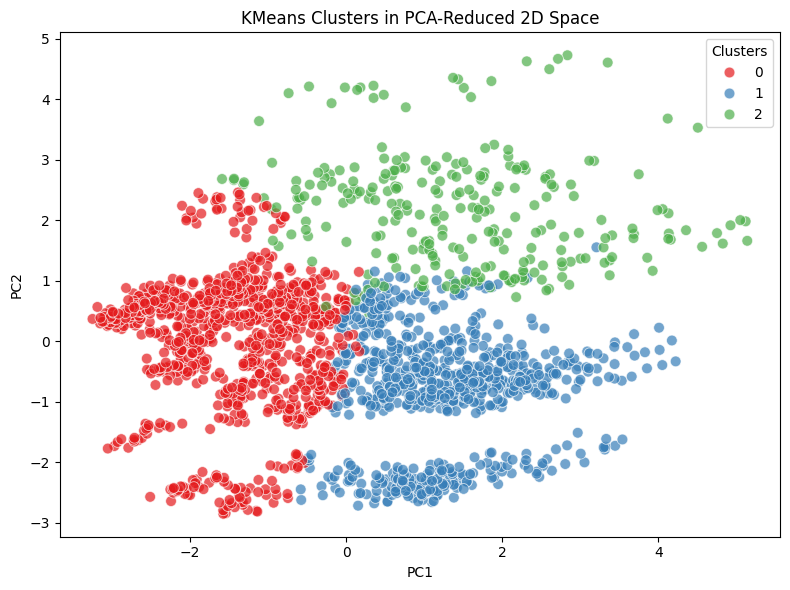

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert selected columns to Pandas for plotting
plot_df = clustered.select("pcaFeatures", "cluster").toPandas()

# Extract PCA components and cluster labels
plot_df[['PC1', 'PC2', 'PC3']] = plot_df['pcaFeatures'].apply(lambda x: pd.Series(x.toArray()))
plot_df['cluster'] = plot_df['cluster'].astype(int)

# Plotting in 2D
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="cluster", palette="Set1", s=60, alpha=0.7)

plt.title("KMeans Clusters in PCA-Reduced 2D Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clusters")
plt.tight_layout()
plt.show()


In [6]:
spark.stop()
"""
### Explanation of the 2D Scatter Plot:

The plot shows the data after reducing its dimensions to 2 using **Principal Component Analysis (PCA)**, and it visualizes how **KMeans clustering** grouped the data into clusters.

- **X-axis (PC1)** and **Y-axis (PC2)**: These represent the two most important features (principal components) of the data after PCA, which explain the most variation in the data.

- **Clusters**: Each color represents a different cluster from the **KMeans algorithm**. The data points within the same color belong to the same cluster.

- **Cluster Separation**: If the clusters are far apart, it means KMeans successfully separated the data. If they are close together, it means KMeans had trouble finding clear clusters.

This plot helps you see how the data is grouped after PCA and how well KMeans separated the data into clusters.

"""